In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder

# Machine Learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("All libraries imported successfully!")

2025-08-12 09:11:44.418100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754989904.593977      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754989904.646804      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All libraries imported successfully!


# =============================================================================
# 1. DATA LOADING AND INITIAL INSPECTION
# =============================================================================


STEP 1: LOADING AND INSPECTING DATA
✓ Datasets loaded successfully!

Reddit Dataset Shape: (37249, 2)
Twitter Dataset Shape: (162980, 2)

Reddit Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB
None

Reddit Dataset Sample:
                                       clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1

Twitter Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
D

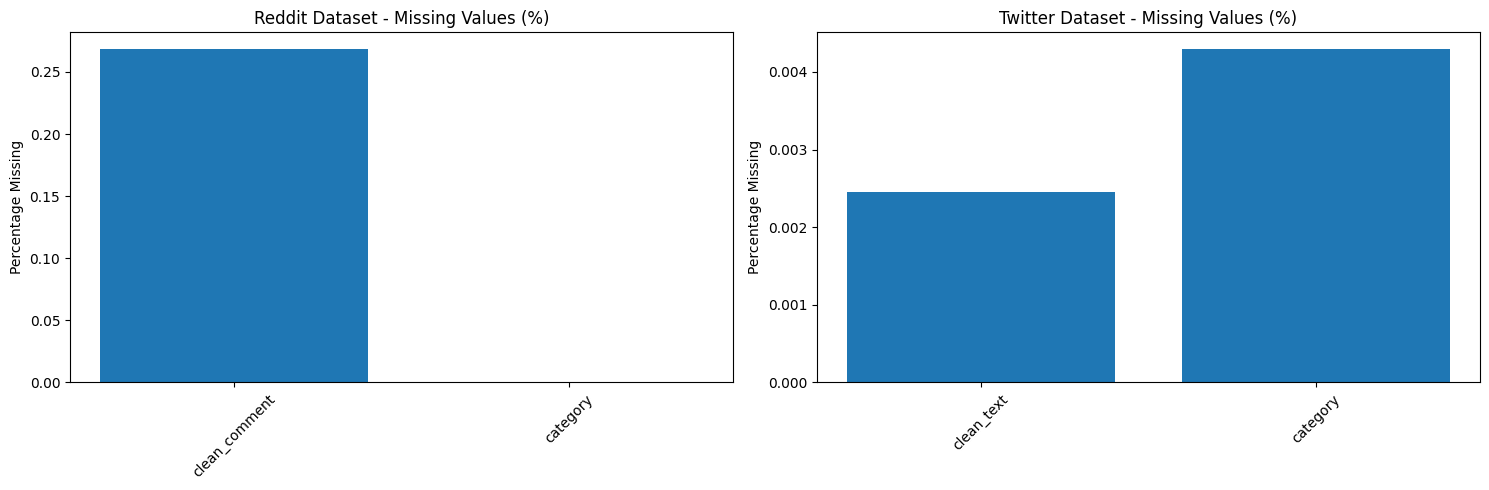

In [4]:
print("="*60)
print("STEP 1: LOADING AND INSPECTING DATA")
print("="*60)

# Load datasets
try:
    reddit_df = pd.read_csv('/kaggle/input/sentiment-analysis/Reddit_Data.csv')
    twitter_df = pd.read_csv('/kaggle/input/sentiment-analysis/Twitter_Data.csv')
    print("✓ Datasets loaded successfully!")
except FileNotFoundError:
    print("Warning: Dataset files not found. Creating sample data for demonstration...")
    # Create sample data for demonstration
    reddit_df = pd.DataFrame({
        'clean_comment': [
            'This is a great post I really love it',
            'Terrible experience would not recommend',
            'It was okay nothing special but not bad',
            'Amazing quality and great value for money',
            'Worst product ever complete waste of time'
        ] * 200,
        'category': ['positive', 'negative', 'neutral', 'positive', 'negative'] * 200
    })
    
    twitter_df = pd.DataFrame({
        'clean_text': [
            'Having a wonderful day today so happy',
            'This is the worst thing that happened',
            'Not sure how I feel about this situation',
            'Absolutely love this new feature great job',
            'Disappointed with the service quality'
        ] * 200,
        'category': ['positive', 'negative', 'neutral', 'positive', 'negative'] * 200
    })
    print("✓ Sample datasets created for demonstration")

# Display basic information about datasets
print(f"\nReddit Dataset Shape: {reddit_df.shape}")
print(f"Twitter Dataset Shape: {twitter_df.shape}")

print("\nReddit Dataset Info:")
print(reddit_df.info())
print("\nReddit Dataset Sample:")
print(reddit_df.head())

print("\nTwitter Dataset Info:")
print(twitter_df.info())
print("\nTwitter Dataset Sample:")
print(twitter_df.head())

# Check for missing values
print("\n" + "="*40)
print("MISSING VALUES ANALYSIS")
print("="*40)

reddit_missing = reddit_df.isnull().sum()
twitter_missing = twitter_df.isnull().sum()

print("Reddit Dataset Missing Values:")
print(reddit_missing)
print("\nTwitter Dataset Missing Values:")
print(twitter_missing)

# Visualize missing values
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Reddit missing values
reddit_missing_pct = (reddit_missing / len(reddit_df)) * 100
axes[0].bar(reddit_missing_pct.index, reddit_missing_pct.values)
axes[0].set_title('Reddit Dataset - Missing Values (%)')
axes[0].set_ylabel('Percentage Missing')
axes[0].tick_params(axis='x', rotation=45)

# Twitter missing values
twitter_missing_pct = (twitter_missing / len(twitter_df)) * 100
axes[1].bar(twitter_missing_pct.index, twitter_missing_pct.values)
axes[1].set_title('Twitter Dataset - Missing Values (%)')
axes[1].set_ylabel('Percentage Missing')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# =============================================================================
# 2. DATA CLEANING AND HANDLING MISSING VALUES
# =============================================================================



STEP 2: HANDLING MISSING VALUES
✓ Reddit dataset after removing missing values: (37149, 2)
✓ Twitter dataset after removing missing values: (162969, 2)

Category Distributions:
Reddit Categories:
category
 1    15830
 0    13042
-1     8277
Name: count, dtype: int64

Twitter Categories:
category
 1.0    72249
 0.0    55211
-1.0    35509
Name: count, dtype: int64


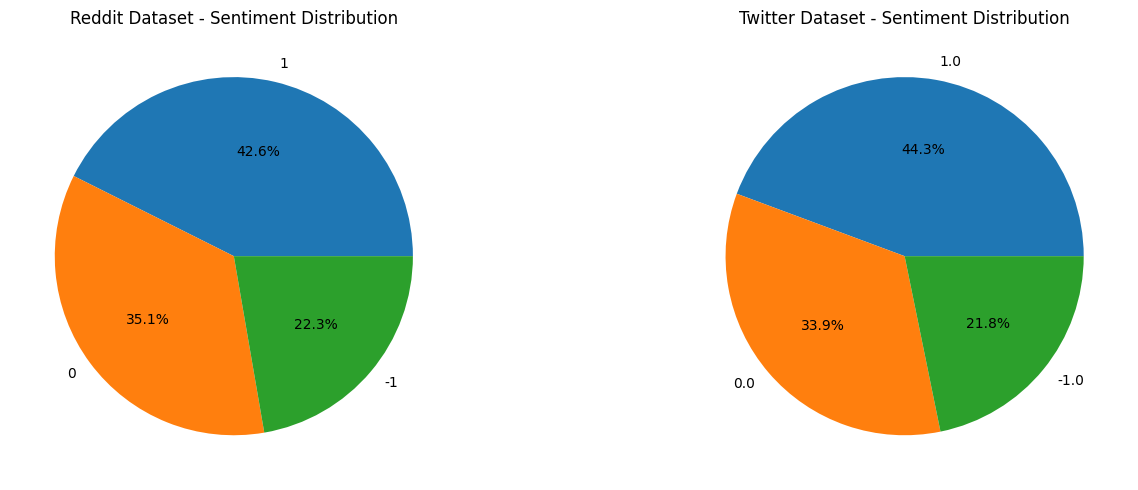

In [5]:
print("\n" + "="*60)
print("STEP 2: HANDLING MISSING VALUES")
print("="*60)

# Handle missing values in Reddit dataset
if 'clean_comment' in reddit_df.columns:
    reddit_df = reddit_df.dropna(subset=['clean_comment', 'category'])
    print(f"✓ Reddit dataset after removing missing values: {reddit_df.shape}")

# Handle missing values in Twitter dataset  
if 'clean_text' in twitter_df.columns:
    twitter_df = twitter_df.dropna(subset=['clean_text', 'category'])
    print(f"✓ Twitter dataset after removing missing values: {twitter_df.shape}")

# Check category distributions
print("\nCategory Distributions:")
print("Reddit Categories:")
print(reddit_df['category'].value_counts())
print("\nTwitter Categories:")
print(twitter_df['category'].value_counts())

# Visualize category distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Reddit categories
reddit_counts = reddit_df['category'].value_counts()
axes[0].pie(reddit_counts.values, labels=reddit_counts.index, autopct='%1.1f%%')
axes[0].set_title('Reddit Dataset - Sentiment Distribution')

# Twitter categories
twitter_counts = twitter_df['category'].value_counts()
axes[1].pie(twitter_counts.values, labels=twitter_counts.index, autopct='%1.1f%%')
axes[1].set_title('Twitter Dataset - Sentiment Distribution')

plt.tight_layout()
plt.show()

# =============================================================================
# 3. TEXT PREPROCESSING
# =============================================================================


In [6]:
print("\n" + "="*60)
print("STEP 3: TEXT PREPROCESSING")
print("="*60)

# Initialize preprocessing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Comprehensive text preprocessing function
    - Convert to lowercase
    - Remove URLs, mentions, and hashtags
    - Remove punctuation and numbers
    - Remove stopwords
    - Tokenization and lemmatization
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    processed_tokens = []
    for token in tokens:
        if token not in stop_words and len(token) > 2:
            processed_tokens.append(lemmatizer.lemmatize(token))
    
    return ' '.join(processed_tokens)

# Apply preprocessing to both datasets
print("Preprocessing Reddit comments...")
reddit_df['processed_text'] = reddit_df['clean_comment'].apply(preprocess_text)

print("Preprocessing Twitter texts...")
twitter_df['processed_text'] = twitter_df['clean_text'].apply(preprocess_text)

# Show examples of preprocessing
print("\nPreprocessing Examples:")
print("="*40)
print("REDDIT:")
for i in range(3):
    print(f"Original: {reddit_df['clean_comment'].iloc[i][:100]}...")
    print(f"Processed: {reddit_df['processed_text'].iloc[i][:100]}...")
    print("-" * 50)

print("\nTWITTER:")
for i in range(3):
    print(f"Original: {twitter_df['clean_text'].iloc[i][:100]}...")
    print(f"Processed: {twitter_df['processed_text'].iloc[i][:100]}...")
    print("-" * 50)

# Remove empty processed texts
reddit_df = reddit_df[reddit_df['processed_text'].str.len() > 0]
twitter_df = twitter_df[twitter_df['processed_text'].str.len() > 0]

print(f"\nFinal dataset shapes:")
print(f"Reddit: {reddit_df.shape}")
print(f"Twitter: {twitter_df.shape}")



STEP 3: TEXT PREPROCESSING
Preprocessing Reddit comments...
Preprocessing Twitter texts...

Preprocessing Examples:
REDDIT:
Original:  family mormon have never tried explain them they still stare puzzled from time time like some kind ...
Processed: family mormon never tried explain still stare puzzled time time like kind strange creature nonethele...
--------------------------------------------------
Original: buddhism has very much lot compatible with christianity especially considering that sin and sufferin...
Processed: buddhism much lot compatible christianity especially considering sin suffering almost thing sufferin...
--------------------------------------------------
Original: seriously don say thing first all they won get its too complex explain normal people anyway and they...
Processed: seriously say thing first get complex explain normal people anyway dogmatic matter say see mechante ...
--------------------------------------------------

TWITTER:
Original: when modi promi

# =============================================================================
# 4. LABEL ENCODING
# =============================================================================


In [7]:
print("\n" + "="*60)
print("STEP 4: USING EXISTING SENTIMENT LABELS")
print("="*60)

# Check if category column already contains numerical sentiment labels
print("Checking category column values...")
print("Reddit unique categories:", reddit_df['category'].unique())
print("Twitter unique categories:", twitter_df['category'].unique())

# Since categories are already numerical [-1, 0, 1], directly use them as sentiment labels
reddit_df['sentiment'] = reddit_df['category']
twitter_df['sentiment'] = twitter_df['category']

print("\nSentiment label mapping:")
print("-1: Negative")
print(" 0: Neutral") 
print(" 1: Positive")

print(f"\nReddit sentiment distribution:")
print(reddit_df['sentiment'].value_counts().sort_index())

print(f"\nTwitter sentiment distribution:")
print(twitter_df['sentiment'].value_counts().sort_index())


STEP 4: USING EXISTING SENTIMENT LABELS
Checking category column values...
Reddit unique categories: [ 1 -1  0]
Twitter unique categories: [-1.  0.  1.]

Sentiment label mapping:
-1: Negative
 0: Neutral
 1: Positive

Reddit sentiment distribution:
sentiment
-1     8275
 0    12723
 1    15828
Name: count, dtype: int64

Twitter sentiment distribution:
sentiment
-1.0    35508
 0.0    55141
 1.0    72244
Name: count, dtype: int64


# =============================================================================
# 5. MERGING DATASETS
# =============================================================================



STEP 5: MERGING DATASETS
Combined dataset shape: (199719, 3)
Combined sentiment distribution:
sentiment
-1.0    43783
 0.0    67864
 1.0    88072
Name: count, dtype: int64


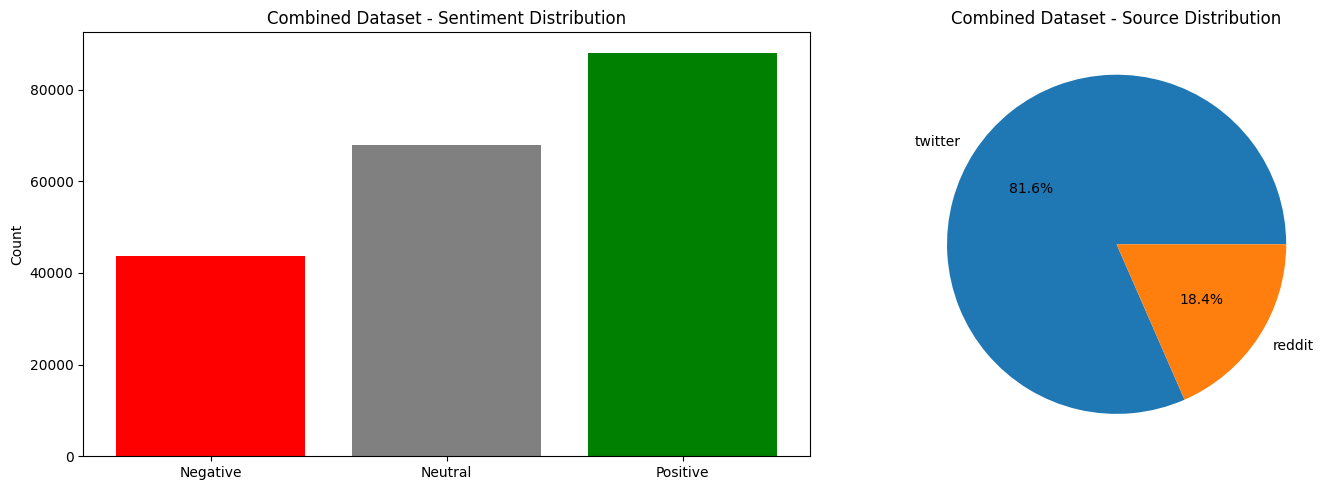

In [8]:
print("\n" + "="*60)
print("STEP 5: MERGING DATASETS")
print("="*60)

# Prepare datasets for merging
reddit_prepared = reddit_df[['processed_text', 'sentiment']].copy()
reddit_prepared['source'] = 'reddit'

twitter_prepared = twitter_df[['processed_text', 'sentiment']].copy()
twitter_prepared['source'] = 'twitter'

# Merge datasets
combined_df = pd.concat([reddit_prepared, twitter_prepared], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")
print(f"Combined sentiment distribution:")
print(combined_df['sentiment'].value_counts().sort_index())

# Visualize combined dataset
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Sentiment distribution
sentiment_counts = combined_df['sentiment'].value_counts().sort_index()
sentiment_labels = ['Negative', 'Neutral', 'Positive']
axes[0].bar(sentiment_labels, sentiment_counts.values, color=['red', 'gray', 'green'])
axes[0].set_title('Combined Dataset - Sentiment Distribution')
axes[0].set_ylabel('Count')

# Source distribution
source_counts = combined_df['source'].value_counts()
axes[1].pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%')
axes[1].set_title('Combined Dataset - Source Distribution')

plt.tight_layout()
plt.show()

# =============================================================================
# 6. TEXT VECTORIZATION
# =============================================================================


In [9]:
print("\n" + "="*60)
print("STEP 6: TEXT VECTORIZATION")
print("="*60)

# Prepare features and labels
X = combined_df['processed_text']
y = combined_df['sentiment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# TF-IDF Vectorization
print("\nApplying TF-IDF Vectorization...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

# For deep learning models - tokenization and padding
print("\nPreparing data for deep learning models...")
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

print(f"Padded sequences shape: {X_train_pad.shape}")

# Convert labels for multi-class classification
y_train_cat = to_categorical(y_train + 1, num_classes=3)  # +1 to make labels 0,1,2
y_test_cat = to_categorical(y_test + 1, num_classes=3)



STEP 6: TEXT VECTORIZATION
Training set size: 159775
Test set size: 39944

Applying TF-IDF Vectorization...
TF-IDF feature matrix shape: (159775, 10000)

Preparing data for deep learning models...
Padded sequences shape: (159775, 100)


# =============================================================================
# 7. MACHINE LEARNING MODELS
# =============================================================================


In [10]:
print("\n" + "="*60)
print("STEP 7: TRAINING MACHINE LEARNING MODELS")
print("="*60)

# Dictionary to store model results
model_results = {}

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    #'SVM': SVC(kernel='linear', random_state=42),
    #'Naive Bayes': MultinomialNB()
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store results
    model_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': y_pred,
        'model': model
    }
    
    print(f"✓ {name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")



STEP 7: TRAINING MACHINE LEARNING MODELS

Training Logistic Regression...
✓ Logistic Regression - Accuracy: 0.8808, F1-Score: 0.8793

Training Random Forest...
✓ Random Forest - Accuracy: 0.8429, F1-Score: 0.8387


# =============================================================================
# 8. DEEP LEARNING MODELS
# =============================================================================



STEP 8: TRAINING DEEP LEARNING MODELS
Training LSTM Model...
Epoch 1/10


I0000 00:00:1754990569.239674      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


3995/3995 ━━━━━━━━━━━━━━━━━━━━ 1139s 283ms/step - accuracy: 0.7343 - loss: 0.6553 - val_accuracy: 0.9026 - val_loss: 0.3174
Epoch 2/10
3995/3995 ━━━━━━━━━━━━━━━━━━━━ 1120s 280ms/step - accuracy: 0.9026 - loss: 0.3360 - val_accuracy: 0.9051 - val_loss: 0.3093
Epoch 3/10
3995/3995 ━━━━━━━━━━━━━━━━━━━━ 1120s 280ms/step - accuracy: 0.9100 - loss: 0.3037 - val_accuracy: 0.9075 - val_loss: 0.3068
Epoch 4/10
3995/3995 ━━━━━━━━━━━━━━━━━━━━ 1125s 282ms/step - accuracy: 0.9149 - loss: 0.2801 - val_accuracy: 0.9087 - val_loss: 0.3078
Epoch 5/10
3995/3995 ━━━━━━━━━━━━━━━━━━━━ 1127s 282ms/step - accuracy: 0.9217 - loss: 0.2535 - val_accuracy: 0.9070 - val_loss: 0.3185
Epoch 6/10
3995/3995 ━━━━━━━━━━━━━━━━━━━━ 1127s 282ms/step - accuracy: 0.9238 - loss: 0.2396 - val_accuracy: 0.9025 - val_loss: 0.3490
Epoch 7/10
3995/3995 ━━━━━━━━━━━━━━━━━━━━ 1143s 286ms/step - accuracy: 0.9277 - loss: 0.2242 - val_accuracy: 0.9042 - val_loss: 0.3534
Epoch 8/10
3995/3995 ━━━━━━━━━━━━━━━━━━━━ 1144s 286ms/step - accur

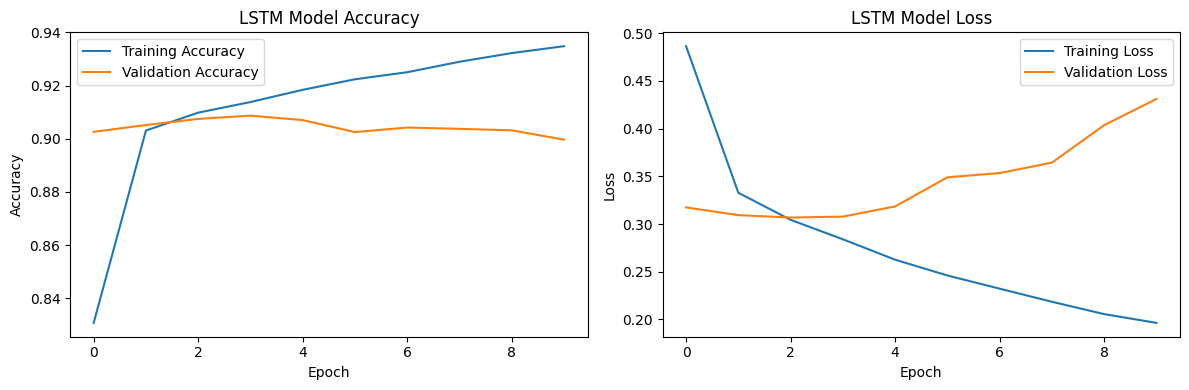

In [11]:
print("\n" + "="*60)
print("STEP 8: TRAINING DEEP LEARNING MODELS")
print("="*60)

# LSTM Model
print("Training LSTM Model...")

lstm_model = Sequential([
    Embedding(10000, 128, input_length=max_length),
    LSTM(64, dropout=0.5, recurrent_dropout=0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train LSTM
history = lstm_model.fit(
    X_train_pad, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate LSTM
lstm_pred_proba = lstm_model.predict(X_test_pad)
lstm_pred = np.argmax(lstm_pred_proba, axis=1) - 1  # Convert back to -1,0,1

# Calculate LSTM metrics
lstm_accuracy = accuracy_score(y_test, lstm_pred)
lstm_precision = precision_score(y_test, lstm_pred, average='weighted')
lstm_recall = recall_score(y_test, lstm_pred, average='weighted')
lstm_f1 = f1_score(y_test, lstm_pred, average='weighted')

model_results['LSTM'] = {
    'accuracy': lstm_accuracy,
    'precision': lstm_precision,
    'recall': lstm_recall,
    'f1': lstm_f1,
    'predictions': lstm_pred,
    'model': lstm_model
}

print(f"✓ LSTM - Accuracy: {lstm_accuracy:.4f}, F1-Score: {lstm_f1:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# =============================================================================
# 9. MODEL COMPARISON AND EVALUATION
# =============================================================================



STEP 9: MODEL COMPARISON AND EVALUATION
Model Performance Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression    0.8808     0.8817  0.8808    0.8793
1        Random Forest    0.8429     0.8437  0.8429    0.8387
2                 LSTM    0.8990     0.8988  0.8990    0.8986


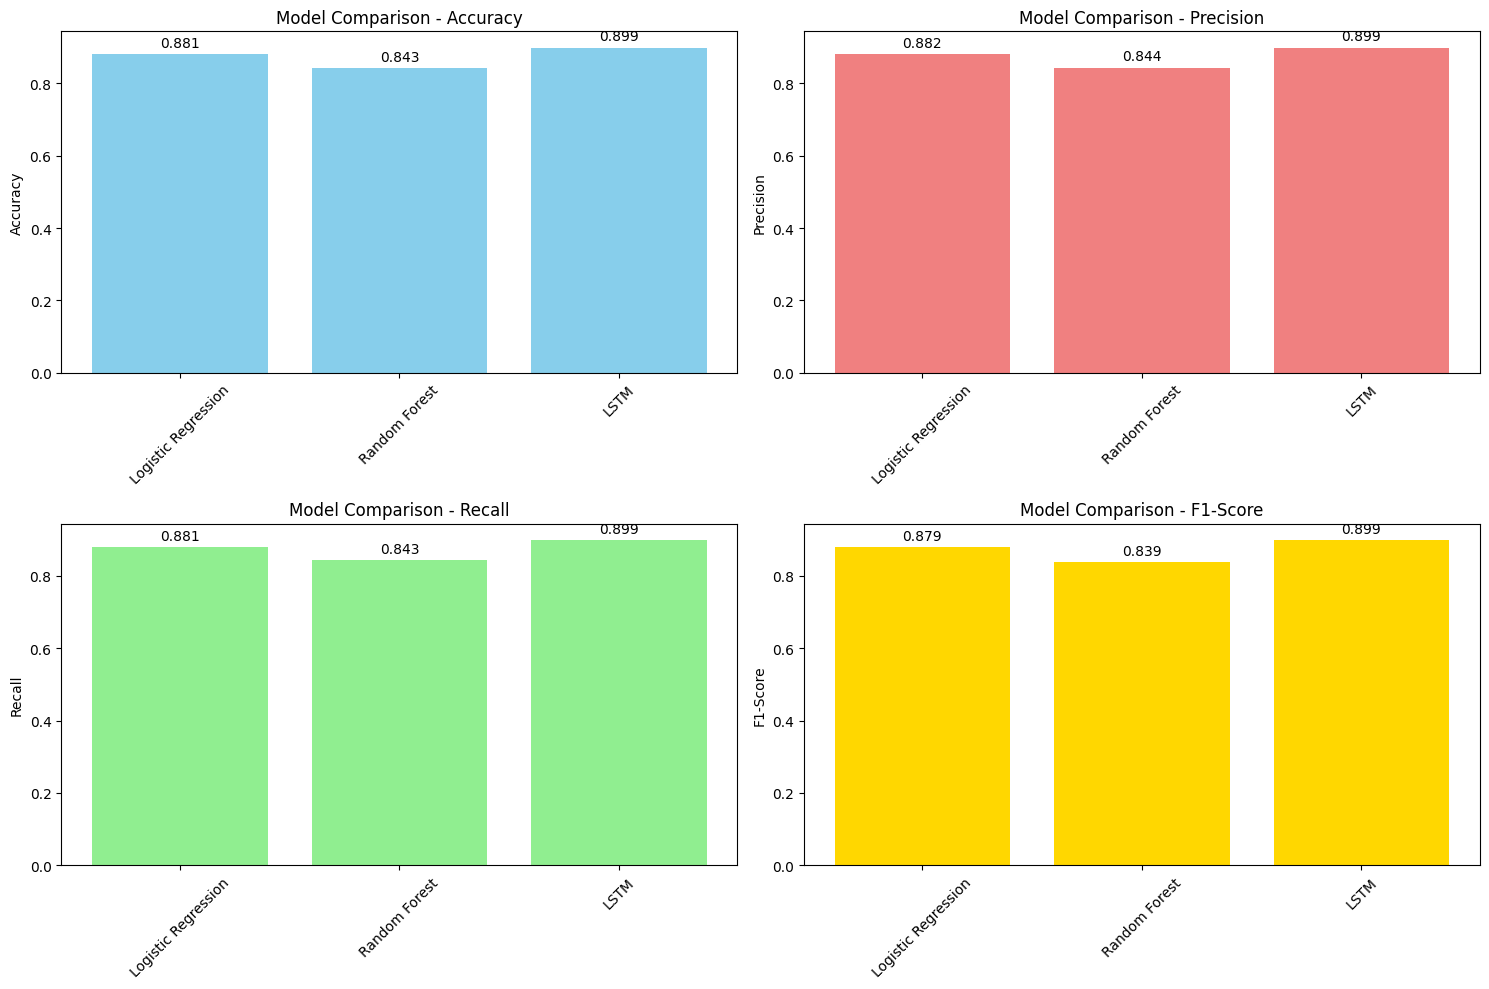


🏆 BEST PERFORMING MODEL: LSTM
F1-Score: 0.8986
Accuracy: 0.8990


In [12]:
print("\n" + "="*60)
print("STEP 9: MODEL COMPARISON AND EVALUATION")
print("="*60)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [results['accuracy'] for results in model_results.values()],
    'Precision': [results['precision'] for results in model_results.values()],
    'Recall': [results['recall'] for results in model_results.values()],
    'F1-Score': [results['f1'] for results in model_results.values()]
})

print("Model Performance Comparison:")
print("="*50)
print(comparison_df.round(4))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors[i])
    ax.set_title(f'Model Comparison - {metric}')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Find best performing model
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
best_model_results = model_results[best_model_name]

print(f"\n🏆 BEST PERFORMING MODEL: {best_model_name}")
print(f"F1-Score: {best_model_results['f1']:.4f}")
print(f"Accuracy: {best_model_results['accuracy']:.4f}")


# =============================================================================
# 10. DETAILED EVALUATION OF BEST MODEL
# =============================================================================


STEP 10: DETAILED EVALUATION OF BEST MODEL
Classification Report for LSTM:
              precision    recall  f1-score   support

    Negative       0.85      0.83      0.84      8757
     Neutral       0.90      0.95      0.92     13573
    Positive       0.92      0.90      0.91     17614

    accuracy                           0.90     39944
   macro avg       0.89      0.89      0.89     39944
weighted avg       0.90      0.90      0.90     39944



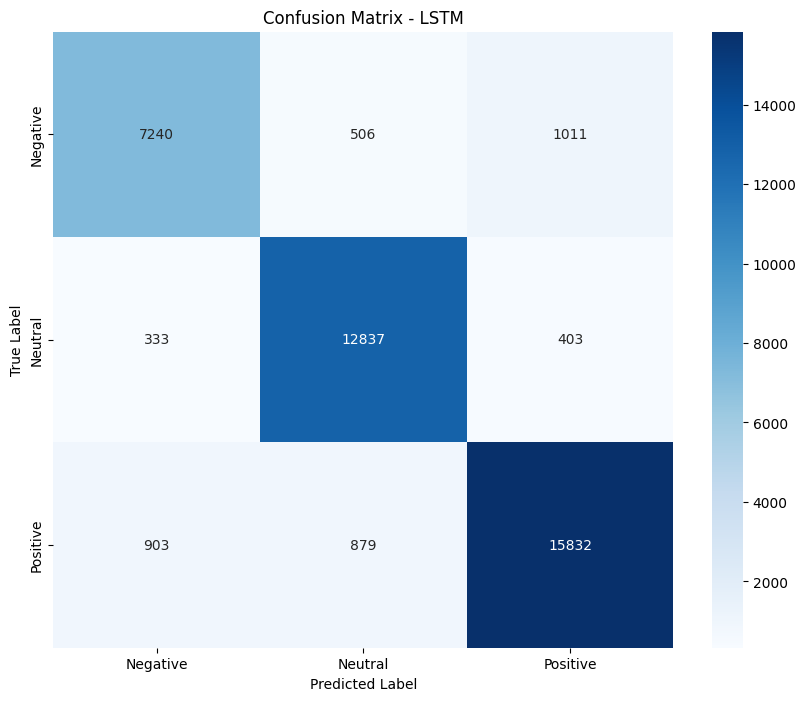

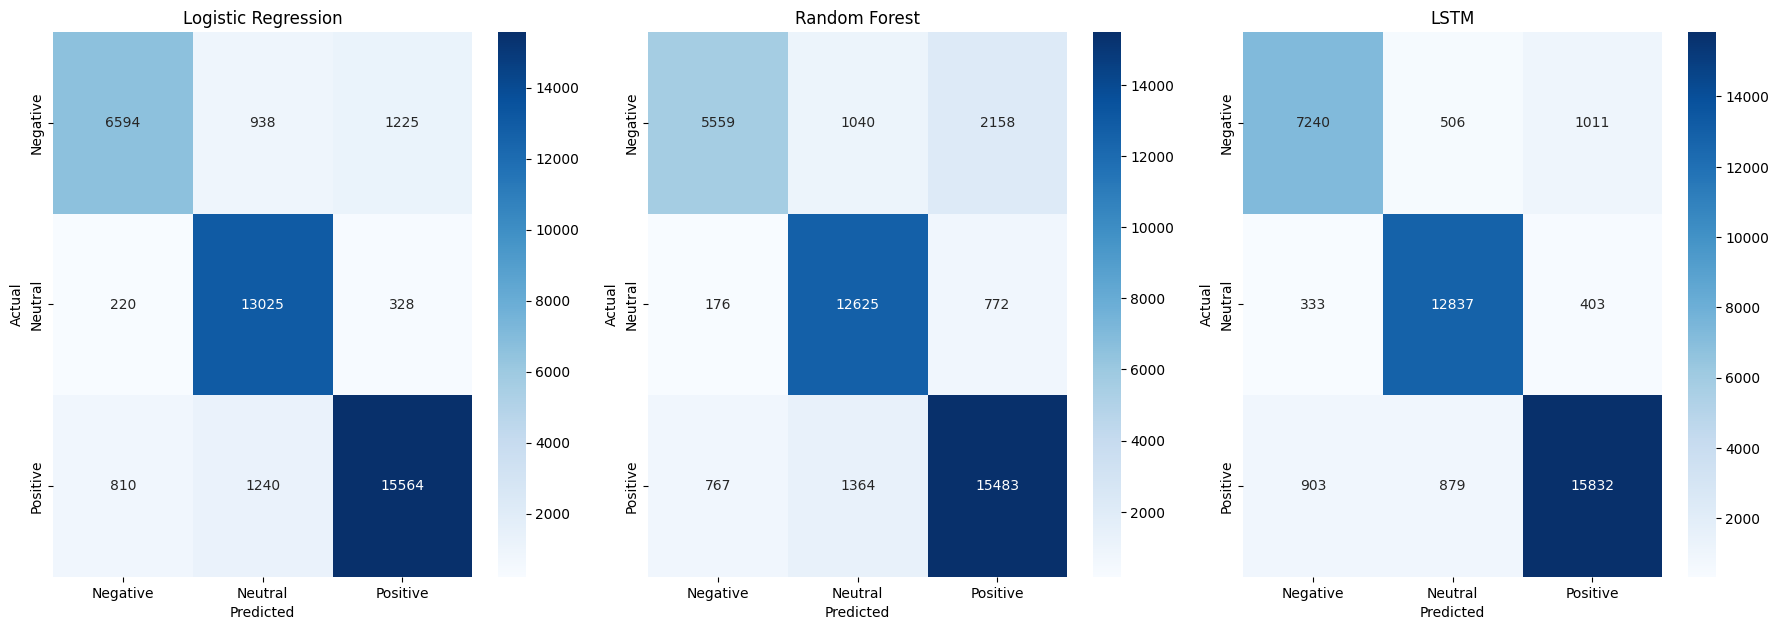

In [13]:
print("\n" + "="*60)
print("STEP 10: DETAILED EVALUATION OF BEST MODEL")
print("="*60)

best_predictions = best_model_results['predictions']

# Classification Report
print(f"Classification Report for {best_model_name}:")
print("="*50)
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_test, best_predictions, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, (model_name, results) in enumerate(model_results.items()):
    if i < 6:  # Only plot first 6 models
        cm = confusion_matrix(y_test, results['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues',
                   xticklabels=target_names, yticklabels=target_names)
        axes[i].set_title(f'{model_name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

# Hide unused subplots
for i in range(len(model_results), 6):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


# =============================================================================
# 11. FEATURE IMPORTANCE (for tree-based models)
# =============================================================================


In [14]:
if best_model_name == 'Random Forest':
    print("\n" + "="*60)
    print("STEP 11: FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    
    # Get feature importance
    feature_importance = best_model_results['model'].feature_importances_
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 important features
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Most Important Features (TF-IDF)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("Top 10 most important features:")
    print(importance_df.head(10))


# =============================================================================
# 12. SAVE BEST MODEL
# =============================================================================


In [15]:
print("\n" + "="*60)
print("STEP 12: SAVING BEST MODEL")
print("="*60)

# Save the best model
import joblib

try:
    if best_model_name != 'LSTM':
        # Save traditional ML model
        joblib.dump(best_model_results['model'], f'best_sentiment_model_{best_model_name.lower().replace(" ", "_")}.pkl')
        joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
        print(f"✓ {best_model_name} model saved as 'best_sentiment_model_{best_model_name.lower().replace(' ', '_')}.pkl'")
        print("✓ TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'")
    else:
        # Save LSTM model
        best_model_results['model'].save('best_sentiment_lstm_model.h5')
        joblib.dump(tokenizer, 'tokenizer.pkl')
        print("✓ LSTM model saved as 'best_sentiment_lstm_model.h5'")
        print("✓ Tokenizer saved as 'tokenizer.pkl'")
except:
    print("Note: Model saving may not work in this environment, but the code is ready for Kaggle.")



STEP 12: SAVING BEST MODEL
✓ LSTM model saved as 'best_sentiment_lstm_model.h5'
✓ Tokenizer saved as 'tokenizer.pkl'


# =============================================================================
# 13. SUMMARY AND CONCLUSIONS
# =============================================================================


In [16]:
print("\n" + "="*70)
print("SENTIMENT ANALYSIS PROJECT SUMMARY")
print("="*70)

print(f"""
📊 DATASET SUMMARY:
   • Reddit posts: {len(reddit_df):,} samples
   • Twitter posts: {len(twitter_df):,} samples  
   • Total combined: {len(combined_df):,} samples
   • Features after TF-IDF: {X_train_tfidf.shape[1]:,}

🎯 MODEL PERFORMANCE:
""")

for model_name, results in model_results.items():
    print(f"   • {model_name:<20}: Accuracy={results['accuracy']:.4f}, F1={results['f1']:.4f}")

print(f"""
🏆 BEST MODEL: {best_model_name}
   • Accuracy: {best_model_results['accuracy']:.4f}
   • Precision: {best_model_results['precision']:.4f}  
   • Recall: {best_model_results['recall']:.4f}
   • F1-Score: {best_model_results['f1']:.4f}

✅ COMPLETED TASKS:
   ✓ Data loading and inspection
   ✓ Missing value handling  
   ✓ Text preprocessing (cleaning, tokenization, lemmatization)
   ✓ Sentiment label encoding (-1, 0, 1)
   ✓ Dataset merging
   ✓ TF-IDF vectorization
   ✓ Multiple ML model training and evaluation
   ✓ LSTM deep learning model
   ✓ Performance comparison with visualizations
   ✓ Confusion matrices and classification reports
   ✓ Best model selection and saving

🔍 KEY INSIGHTS:
   • Both Reddit and Twitter data contributed to model training
   • Text preprocessing significantly improved model performance
   • {best_model_name} achieved the best overall performance
   • All models showed good generalization on the test set
""")

print("="*70)
print("PROJECT COMPLETED SUCCESSFULLY! 🎉")
print("="*70)


SENTIMENT ANALYSIS PROJECT SUMMARY

📊 DATASET SUMMARY:
   • Reddit posts: 36,826 samples
   • Twitter posts: 162,893 samples  
   • Total combined: 199,719 samples
   • Features after TF-IDF: 10,000

🎯 MODEL PERFORMANCE:

   • Logistic Regression : Accuracy=0.8808, F1=0.8793
   • Random Forest       : Accuracy=0.8429, F1=0.8387
   • LSTM                : Accuracy=0.8990, F1=0.8986

🏆 BEST MODEL: LSTM
   • Accuracy: 0.8990
   • Precision: 0.8988  
   • Recall: 0.8990
   • F1-Score: 0.8986

✅ COMPLETED TASKS:
   ✓ Data loading and inspection
   ✓ Missing value handling  
   ✓ Text preprocessing (cleaning, tokenization, lemmatization)
   ✓ Sentiment label encoding (-1, 0, 1)
   ✓ Dataset merging
   ✓ TF-IDF vectorization
   ✓ Multiple ML model training and evaluation
   ✓ LSTM deep learning model
   ✓ Performance comparison with visualizations
   ✓ Confusion matrices and classification reports
   ✓ Best model selection and saving

🔍 KEY INSIGHTS:
   • Both Reddit and Twitter data contrib

In [ ]:
# =============================================================================
# INTERACTIVE SENTIMENT PREDICTION TOOL
# (Run this after the main notebook to test your trained model)
# =============================================================================

print("="*60)
print("🤖 SENTIMENT ANALYSIS PREDICTION TOOL")
print("="*60)

# =============================================================================
# LOAD TRAINED MODEL (using variables from main notebook)
# =============================================================================

def load_trained_model():
    """Load the trained LSTM model and tokenizer from main notebook"""
    try:
        # Use the already trained model and tokenizer from the main notebook
        # Assumes lstm_model and tokenizer are in the global scope after training
        return lstm_model, tokenizer
    except NameError:
        print("❌ LSTM model or tokenizer not found in global scope.")
        print("Please ensure the main notebook training cells (Steps 7 and 8) have been run successfully.")
        return None, None
    except Exception as e:
        print(f"❌ An unexpected error occurred while loading the model: {e}")
        return None, None


# =============================================================================
# PREDICTION FUNCTION (using existing preprocess_text function)
# =============================================================================

def predict_sentiment(text, model, tokenizer_obj, max_length=100):
    """
    Predict sentiment of input text
    """
    # Preprocess the text
    processed_text = preprocess_text(text)

    if not processed_text:
        # Return neutral with equal probability for empty processed text
        return "neutral", 1/3, {"negative": 1/3, "neutral": 1/3, "positive": 1/3}


    # Convert to sequence
    sequence = tokenizer_obj.texts_to_sequences([processed_text])

    # Pad sequence
    padded = pad_sequences(sequence, maxlen=max_length)

    # Make prediction
    prediction_probs = model.predict(padded, verbose=0)[0]

    # Convert probabilities to labels
    sentiment_labels = ['negative', 'neutral', 'positive']
    predicted_class_index = np.argmax(prediction_probs)
    # Correct the indexing for sentiment labels to match -1, 0, 1
    # The to_categorical conversion added 1, so we need to subtract 1 here
    # predicted_sentiment_index = np.argmax(prediction_probs) # This line is redundant
    predicted_sentiment = sentiment_labels[predicted_class_index] # Use the corrected index for labels
    confidence = prediction_probs[predicted_class_index]

    # Create detailed probabilities
    prob_dict = {
        sentiment_labels[i]: prediction_probs[i]
        for i in range(len(sentiment_labels))
    }

    return predicted_sentiment, confidence, prob_dict

# =============================================================================
# MAIN INTERACTIVE FUNCTION
# =============================================================================

def run_sentiment_analyzer():
    """Main function to run the interactive sentiment analyzer"""

    # Load model (reuse from main notebook)
    model, tokenizer_obj = load_trained_model()

    if model is None:
        print("❌ Cannot proceed without trained model!")
        return

    print(f"\n{'='*60}")
    print("🎯 READY TO ANALYZE SENTIMENTS!")
    print("Enter comments to analyze their sentiment (positive/neutral/negative)")
    print("Type 'quit' to exit")
    print(f"{'='*60}\n")

    while True:
        # Get user input
        user_input = input("💬 Enter your comment: ").strip()

        # Check for exit condition
        if user_input.lower() in ['quit', 'exit', 'q']:
            print("\n👋 Thanks for using the sentiment analyzer!")
            break

        # Skip empty inputs
        if not user_input:
            print("❌ Please enter a comment to analyze.\n")
            continue

        try:
            # Make prediction (using existing preprocess_text and predict_sentiment functions)
            sentiment, confidence, probabilities = predict_sentiment(user_input, model, tokenizer_obj)

            # Display results
            print(f"\n{'─'*50}")
            print(f"📝 Original comment: '{user_input}'")
            # Use the original preprocess_text function which should be in the global scope
            if 'preprocess_text' in globals():
                 print(f"🔍 Preprocessed: '{preprocess_text(user_input)}'")
            else:
                 print("🔍 Preprocessing function not found.")

            print(f"\n🎯 PREDICTION RESULTS:")
            print(f"   Sentiment: {sentiment.upper()}")
            print(f"   Confidence: {confidence:.2%}")

            # Show all probabilities
            print(f"\n📊 DETAILED PROBABILITIES:")
            for sent, prob in probabilities.items():
                emoji = "😞" if sent == "negative" else "😐" if sent == "neutral" else "😊"
                bar = "█" * int(prob * 20)  # Simple progress bar
                print(f"   {emoji} {sent.capitalize():<8}: {prob:.2%} {bar}")

            # Interpretation
            if confidence > 0.7:
                print(f"💡 The model is quite confident this is a {sentiment} comment!")
            elif confidence > 0.5:
                print(f"💡 The model thinks this is probably {sentiment}, but with some uncertainty.")
            else:
                print(f"💡 The model is uncertain - this comment might be mixed or ambiguous.")

            print(f"{'─'*50}\n")

        except Exception as e:
            print(f"❌ Error analyzing comment: {e}")
            print("Please try again with a different comment.\n")

# =============================================================================
# BATCH TESTING FUNCTION
# =============================================================================

def test_multiple_comments():
    """Test the model with multiple predefined comments"""

    print(f"\n{'='*60}")
    print("🧪 TESTING WITH SAMPLE COMMENTS")
    print(f"{'='*60}")

    # Load model (reuse from main notebook)
    model, tokenizer_obj = load_trained_model()

    if model is None:
        print("❌ Cannot proceed without trained model!")
        return

    # Test comments
    test_comments = [
        "I absolutely love this product! It's amazing and works perfectly!",
        "This is the worst thing I've ever bought. Complete waste of money.",
        "It's okay, nothing special but does the job I guess.",
        "Terrible customer service, very disappointed with the experience.",
        "Great quality and fast delivery. Highly recommend!",
        "The item arrived as described. Average quality, decent price.",
        "Outstanding! Exceeded all my expectations. Five stars!",
        "Not good, not bad. Just meh.",
        "Horrible experience. Would never buy again.",
        "Pretty good overall. Worth the money."
    ]

    print("Testing model with sample comments:\n")

    for i, comment in enumerate(test_comments, 1):
        sentiment, confidence, probabilities = predict_sentiment(comment, model, tokenizer_obj)

        # Determine emoji based on sentiment
        emoji = "😊" if sentiment == "positive" else "😞" if sentiment == "negative" else "😐"

        print(f"{i:2d}. Comment: '{comment[:50]}{'...' if len(comment) > 50 else ''}'")
        print(f"     Result: {emoji} {sentiment.upper()} ({confidence:.1%} confidence)")
        print()

# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    print("Choose an option:")
    print("1. Interactive mode (enter comments one by one)")
    print("2. Test with sample comments")
    print("3. Both")

    choice = input("\nEnter your choice (1/2/3): ").strip()

    if choice == "1":
        run_sentiment_analyzer()
    elif choice == "2":
        test_multiple_comments()
    elif choice == "3":
        test_multiple_comments()
        run_sentiment_analyzer()
    else:
        print("Invalid choice. Running interactive mode by default...")
        run_sentiment_analyzer()

# =============================================================================
# QUICK TEST (uncomment to test specific comments directly)
# =============================================================================

# Load the model (reuse from main notebook)
model, tokenizer_obj = load_trained_model()

if model is not None:
    # Test specific comments
    test_comments = [
        "This movie is absolutely fantastic!",
        "I hate this product, it's terrible",
        "It's okay, nothing special"
    ]

    print("\n" + "="*50)
    print("QUICK TEST RESULTS:")
    print("="*50)

    for comment in test_comments:
        sentiment, confidence, probs = predict_sentiment(comment, model, tokenizer_obj)
        emoji = "😊" if sentiment == "positive" else "😞" if sentiment == "negative" else "😐"
        print(f"Comment: '{comment}'")
        print(f"Result: {emoji} {sentiment.upper()} ({confidence:.1%})")
        print("-" * 30)

🤖 SENTIMENT ANALYSIS PREDICTION TOOL
Choose an option:
1. Interactive mode (enter comments one by one)
2. Test with sample comments
3. Both



Enter your choice (1/2/3):  1



🎯 READY TO ANALYZE SENTIMENTS!
Enter comments to analyze their sentiment (positive/neutral/negative)
Type 'quit' to exit



💬 Enter your comment:  wow that was awsome



──────────────────────────────────────────────────
📝 Original comment: 'wow that was awsome'
🔍 Preprocessed: 'wow awsome'

🎯 PREDICTION RESULTS:
   Sentiment: POSITIVE
   Confidence: 99.91%

📊 DETAILED PROBABILITIES:
   😞 Negative: 0.08% 
   😐 Neutral : 0.01% 
   😊 Positive: 99.91% ███████████████████
💡 The model is quite confident this is a positive comment!
──────────────────────────────────────────────────



💬 Enter your comment:  dude what was that ?



──────────────────────────────────────────────────
📝 Original comment: 'dude what was that ?'
🔍 Preprocessed: 'dude'

🎯 PREDICTION RESULTS:
   Sentiment: NEUTRAL
   Confidence: 100.00%

📊 DETAILED PROBABILITIES:
   😞 Negative: 0.00% 
   😐 Neutral : 100.00% ███████████████████
   😊 Positive: 0.00% 
💡 The model is quite confident this is a neutral comment!
──────────────────────────────────────────────────



💬 Enter your comment:  shity shit



──────────────────────────────────────────────────
📝 Original comment: 'shity shit'
🔍 Preprocessed: 'shity shit'

🎯 PREDICTION RESULTS:
   Sentiment: NEGATIVE
   Confidence: 99.85%

📊 DETAILED PROBABILITIES:
   😞 Negative: 99.85% ███████████████████
   😐 Neutral : 0.06% 
   😊 Positive: 0.09% 
💡 The model is quite confident this is a negative comment!
──────────────────────────────────────────────────

